# Extracting a sub cube from the sparkfits_images table

This notebook demonstrates the procedure to create a sub cube from the main FITS file saved on Parquet. It has been laid out as a point by point demonstration on how to interact with the image tables that have been created in Parquet on HDFS, with a Hive metadata layer to allow access by Hive QL.




#### Changing the Spark context to increase resources
The next two cells demonstrate how to re initialise the spark context within a Jupyter notebook when more resources are allocated. Usually, this is not required; so these cells are only included for information.


In [1]:
newContext=False

In [2]:
if newContext:
    # Set the new configuration
    print("Loading new Spark configuration")
    conf = SparkConf().setAll([('spark.executor.memory', '8g'),\
                               ('spark.driver.memory', '6g'),\
                               ('spark.shuffle.service.enabled', True), \
                               ('spark.sql.shuffle.partitions', 144), \
                               ('spark.default.parallelism', 144),\
                               ('spark.dynamicAllocation.enabled', True), \
                               ('spark.dynamicAllocation.executorIdleTimeout', 600), \
                               ('spark.executor.cores', 4),\
                               ('spark.executor.instances', 25), \
                               ('spark.local.dir','/mnt/FITs/Spark/tmp'),\
                               ('spark.executor.memoryOverhead', '6g'),\
                               ('spark.driver.memoryOverhead', '4g'),\
                               ('spark.rpc.message.maxSize', '512'),\
                               ('spark.scheduler.mode', 'FAIR'),\
                               ('spark.kryoserializer.buffer.max', '1g'),\
                               ('spark.hadoop.hive.exec.dynamic.partition', True), \
                               ('spark.hadoop.hive.exec.dynamic.partition.mode','nonstrict'), \
                               ('spark.hadoop.hive.exec.max.dynamic.partitions', 100000), \
                               ('spark.hadoop.hive.exec.max.dynamic.partitions.pernode', 100000), \
                               ('spark.app.name','Creating FITs dimensions')])

    # Stop the old context
    sc.stop()

    # And restart the context with the new configuration
    sc = SparkContext(conf=conf)
    sqlContext = SQLContext(sc)
    newContext=True

In [3]:
sc

<SparkContext master=yarn appName=pyspark-shell>

In [4]:
sqlContext

## Import the necessary libraries

In [5]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import astropy_mpl_style
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
plt.style.use(astropy_mpl_style)

import numpy as np
from photutils import DAOStarFinder
from astropy.stats import sigma_clipped_stats

from scipy import sparse
from scipy.sparse import csr_matrix

from random import randint
from time import sleep

from spectral_cube import SpectralCube
from astroquery.esasky import ESASky
from astroquery.utils import TableList
from reproject import reproject_interp
import astropy.units as u

from pyspark.sql import SQLContext, SparkSession
from pyspark import StorageLevel

from pyspark import SparkFiles

from pyspark.sql import functions as F
import pyspark.sql.functions as f

from pyspark.sql.functions import randn, monotonically_increasing_id, row_number, desc, udf, col, lit
from pyspark.sql.functions import broadcast, explode, posexplode
from pyspark.sql.types import ArrayType, FloatType,IntegerType, DataType, DoubleType,Row, BooleanType

"""
Set the Spark datatypes
"""
iType=IntegerType()
dType=DoubleType()
fType=FloatType()

from pyspark.sql.functions import pandas_udf, PandasUDFType

from pyspark.sql.window import Window

from pyspark.ml.linalg import Vectors
from pyspark.ml.linalg import SparseVector, DenseVector,VectorUDT

from datetime import datetime

maindir is /home/hduser/.astropy/config
maindir is /home/hduser/.astropy/config
maindir is /home/hduser/.astropy/cache
maindir is /home/hduser/.astropy/cache
maindir is /home/hduser/.astropy/cache
maindir is /home/hduser/.astropy/cache
maindir is /home/hduser/.astropy/cache
maindir is /home/hduser/.astropy/cache
maindir is /home/hduser/.astropy/config
maindir is /home/hduser/.astropy/config
maindir is /home/hduser/.astropy/cache


## Class definitions

In [6]:
from time import time, clock
class Timer:
    """
    a simple class for printing time (s) since last call
    """
    def __init__(self):
        self.t0=time()
        self.t1=clock()
        self.elapsed = 1
        self.elapsedCPU = 1
    
    def start(self):
        self.t0=time()
        self.t1=clock()
        
    def stop(self):
        t1=time()
        t2=clock()
        print("Elapsed {:2.1f}s, CPU {:2.1f}s".format(t1-self.t0, t2-self.t1))
        self.elapsed = t1-self.t0
        self.elapsedCPU = t2-self.t1

timer=Timer()

## Function and UDF definitions

### Functions

In [7]:
def GetDetailArrays(fitsFilename, raType, decType, spectraType):
    sqlStmt=("""
        select sda_detail_array, sda_detail_type
        from Sparkfits_detail_arrays
        where sda_filename='{}'
    """).format(fitsFilename)

    detailsDF=sqlContext.sql(sqlStmt)
    
    raArray=np.array(detailsDF.filter(f.col("sda_detail_type") == raType)\
                     .select(f.col("sda_detail_array")).collect() )
    raArray=raArray.reshape(raArray.shape[2])

    decArray=np.array(detailsDF.filter(f.col("sda_detail_type") == decType)\
                      .select(f.col("sda_detail_array")).collect() )
    decArray=decArray.reshape(decArray.shape[2])

    spectraArray=np.array(detailsDF.filter(f.col("sda_detail_type") == spectraType)\
                          .select(f.col("sda_detail_array")).collect() )
    spectraArray=spectraArray.reshape(spectraArray.shape[2])

    return raArray, decArray, spectraArray

In [8]:
## Nice utilities from Joe Filippazzo
## http://www.bdnyc.org/2012/10/decimal-deg-to-hms/

def deg2HMS(ra='', dec='', round=False):
  RA, DEC, rs, ds = '', '', '', ''
  if dec:
    if str(dec)[0] == '-':
      ds, dec = '-', abs(dec)
    deg = int(dec)
    decM = abs(int((dec-deg)*60))
    if round:
      decS = int((abs((dec-deg)*60)-decM)*60)
    else:
      decS = (abs((dec-deg)*60)-decM)*60
    DEC = '{0}{1} {2} {3}'.format(ds, deg, decM, decS)
  
  if ra:
    if str(ra)[0] == '-':
      rs, ra = '-', abs(ra)
    raH = int(ra/15)
    raM = int(((ra/15)-raH)*60)
    if round:
      raS = int(((((ra/15)-raH)*60)-raM)*60)
    else:
      raS = ((((ra/15)-raH)*60)-raM)*60
    RA = '{0}{1} {2} {3}'.format(rs, raH, raM, raS)
  
  if ra and dec:
    return (RA, DEC)
  else:
    return RA or DEC

def HMS2deg(ra='', dec=''):
  RA, DEC, rs, ds = '', '', 1, 1
  if dec:
    D, M, S = [float(i) for i in dec.split()]
    if str(D)[0] == '-':
      ds, D = -1, abs(D)
    deg = D + (M/60) + (S/3600)
    DEC = '{0}'.format(deg*ds)
  
  if ra:
    H, M, S = [float(i) for i in ra.split()]
    if str(H)[0] == '-':
      rs, H = -1, abs(H)
    deg = (H*15) + (M/4) + (S/240)
    RA = '{0}'.format(deg*rs)
  
  if ra and dec:
    return (RA, DEC)
  else:
    return RA or DEC

## Set up the connection to Hive on HDFS

Set default database to the default Hive database - in this case, "fits_investigation". This example displays the available databases, sets the default database and then shows the database tables.

In [9]:
sqlContext.sql("show databases").show()
sqlContext.sql("use fits_investigation")
sqlContext.sql("show tables").show()


+------------------+
|      databaseName|
+------------------+
|           default|
|fits_investigation|
|          plasticc|
+------------------+

+------------------+--------------------+-----------+
|          database|           tableName|isTemporary|
+------------------+--------------------+-----------+
|fits_investigation|          array_test|      false|
|fits_investigation|declimation_dim_temp|      false|
|fits_investigation|    fits_header_data|      false|
|fits_investigation|          float_test|      false|
|fits_investigation|  imagetestsparkfits|      false|
|fits_investigation|   localparalleltest|      false|
|fits_investigation|localparalleltest...|      false|
|fits_investigation|localparalleltest...|      false|
|fits_investigation|localparalleltest...|      false|
|fits_investigation|  newdfdeletemelater|      false|
|fits_investigation|     parquetdataview|      false|
|fits_investigation|parquetpartitione...|      false|
|fits_investigation|parquetpartitione...| 

## Data extraction

### Get the files we have loaded into Parquet

In [10]:
filesDF=sqlContext.sql("""
    show partitions sparkfits_detail_arrays
""")
filesDF.show(80, False)

+---------------------------------------------------------------------------------------+
|partition                                                                              |
+---------------------------------------------------------------------------------------+
|sda_filename=ASKAPsim_pol1.image.I.restored.fits/sda_detail_type=DEC--SIN              |
|sda_filename=ASKAPsim_pol1.image.I.restored.fits/sda_detail_type=GHz                   |
|sda_filename=ASKAPsim_pol1.image.I.restored.fits/sda_detail_type=Hz                    |
|sda_filename=ASKAPsim_pol1.image.I.restored.fits/sda_detail_type=RA---SIN              |
|sda_filename=ASKAPsim_pol1.image.I.restored.fits/sda_detail_type=km s-1                |
|sda_filename=ASKAPsim_pol1.image.Q.restored.fits/sda_detail_type=DEC--SIN              |
|sda_filename=ASKAPsim_pol1.image.Q.restored.fits/sda_detail_type=GHz                   |
|sda_filename=ASKAPsim_pol1.image.Q.restored.fits/sda_detail_type=Hz                    |
|sda_filen

## Set selection variables

We determine which file, coordinate system and spectra type

In [11]:
fitsFilename='image.restored.i.SB2338.V2.cube.fits'
raType='RA---SIN'
decType='DEC--SIN'
spectraType='Hz'

## Create the header from the initial FITS file
Which is saved in the table "fits_header_data". This table is comprised of the header cards from the original file header saved with an index value to keep them in the original order when being retrieved. The schema of the table and an example listing is shown in the next cell. 

In [12]:
sqlContext.sql("describe fits_header_data").show()
sqlContext.sql("select * from fits_header_data order by index").show(20, False)

+---------+---------+-------+
| col_name|data_type|comment|
+---------+---------+-------+
|fits_file|   string|   null|
|    index|   bigint|   null|
|      key|   string|   null|
|    value|   string|   null|
|  comment|   string|   null|
+---------+---------+-------+

+------------------------------------+-----+-------+---------------+-------------------------------+
|fits_file                           |index|key    |value          |comment                        |
+------------------------------------+-----+-------+---------------+-------------------------------+
|image.restored.i.SB2338.V2.cube.fits|0    |SIMPLE |True           |Standard FITS                  |
|image.restored.i.SB2338.V2.cube.fits|1    |BITPIX |-32            |Floating point (32 bit)        |
|image.restored.i.SB2338.V2.cube.fits|2    |NAXIS  |4              |                               |
|image.restored.i.SB2338.V2.cube.fits|3    |NAXIS1 |5607           |                               |
|image.restored.i.SB23

We'll create the original header from the image.restored.i.SB2338.V2.cube.fits cube file. We've already set the filename we're interested in, so lets extract the data and create the header file.

#### Get the data cards from Parquet and create the header
For clarity, we create a SQL statement we can run against the Hive tables, and we substitute the filename we're interested in.

In [13]:
sqlStmt=("""
        select * 
        from sparkfits_fits_headers
        where sfh_fits_file='{}' 
        order by sfh_index
    """.format(fitsFilename)
        )

Create the header dataframe

In [14]:
hduData=sqlContext.sql(sqlStmt)
hduData.show()


+---------+-------+---------------+--------------------+--------------------+
|sfh_index|sfh_key|      sfh_value|         sfh_comment|       sfh_fits_file|
+---------+-------+---------------+--------------------+--------------------+
|        0| SIMPLE|           True|       Standard FITS|image.restored.i....|
|        1| BITPIX|            -32|Floating point (3...|image.restored.i....|
|        2|  NAXIS|              4|                    |image.restored.i....|
|        3| NAXIS1|           5607|                    |image.restored.i....|
|        4| NAXIS2|           5654|                    |image.restored.i....|
|        5| NAXIS3|              1|                    |image.restored.i....|
|        6| NAXIS4|           2592|                    |image.restored.i....|
|        7| BSCALE|            1.0|PHYSICAL = PIXEL*...|image.restored.i....|
|        8|  BZERO|            0.0|                    |image.restored.i....|
|       10|  BUNIT|        Jy/beam|Brightness (pixel...|image.re

Now that we have the original FITS header cards in the dataframe, we create the original header.

The RetrieveHeader function takes the dataframe we just created as a parameter. We create a new blank fits header, and then use the dataframe to create the cards in the recreated dataframe.

In [15]:
def RetrieveHeader(hduData):
    # Create header file

    hdu=fits.PrimaryHDU()
    hduHeader=hdu.header

    def isFloat(string):
        try:
            float(string)
            return True
        except ValueError:
            return False
    for row in hduData.rdd.toLocalIterator():

        if row.sfh_value=='True':
            v=True
        elif isFloat(row.sfh_value):
            v=float(row.sfh_value)
            pass
        elif row.sfh_value.isnumeric():
            v=int(row.sfh_value)
            pass
        else:
            v=row.sfh_value
        #print(row.key, v) #row.value, row.value.isnumeric(), isFloat(row.value), bool(row.value))
        hduHeader[row.sfh_key] = (v, row.sfh_comment)
        pass
    
    return hduHeader

retrievedHeader = RetrieveHeader(hduData)
retrievedHeader


SIMPLE  =                    T / Standard FITS                                  
BITPIX  =                -32.0 / Floating point (32 bit)                        
NAXIS   =                  4.0                                                  
EXTEND  =                    T                                                  
NAXIS1  =               5607.0                                                  
NAXIS2  =               5654.0                                                  
NAXIS3  =                  1.0                                                  
NAXIS4  =               2592.0                                                  
BSCALE  =                  1.0 / PHYSICAL = PIXEL*BSCALE + BZERO                
BZERO   =                  0.0                                                  
BUNIT   = 'Jy/beam '           / Brightness (pixel) unit                        
EQUINOX =               2000.0                                                  
RADESYS = 'FK5     '        

## Get the sub cube data we want

### Example 1 - full 5607 x 5654 images, for three channels

First, lets describe the table so we know what we're dealing with


In [16]:
sqlContext.sql("desc sparkfits_images").show()

+--------------------+------------+-------+
|            col_name|   data_type|comment|
+--------------------+------------+-------+
|           spi_index|         int|   null|
|           spi_image|array<float>|   null|
|        spi_filename|      string|   null|
|            spi_band|         int|   null|
|# Partition Infor...|            |       |
|          # col_name|   data_type|comment|
|        spi_filename|      string|   null|
|            spi_band|         int|   null|
+--------------------+------------+-------+



As an example, lets assume we're interested in the 14th through 16th channels.

### IMPORTANT!

Include the order by clause when creating the new dataframe - remember Spark has no concept of keeping the correct block order.


In [17]:
newCubeDF=sqlContext.sql("""
select spi_image
from sparkfits_images
where spi_filename='{}'
and spi_band in (14,15,16)
order by spi_band, spi_index
""".format(fitsFilename))

In [18]:
sqlContext.sql("""
select spi_image, spi_band, spi_index
from sparkfits_images
where spi_filename='{}'
and spi_band in (14,15,16)
order by spi_band, spi_index
""".format(fitsFilename)).show()

+--------------------+--------+---------+
|           spi_image|spi_band|spi_index|
+--------------------+--------+---------+
|[NaN, NaN, NaN, N...|      14|        0|
|[NaN, NaN, NaN, N...|      14|        1|
|[NaN, NaN, NaN, N...|      14|        2|
|[NaN, NaN, NaN, N...|      14|        3|
|[NaN, NaN, NaN, N...|      14|        4|
|[NaN, NaN, NaN, N...|      14|        5|
|[NaN, NaN, NaN, N...|      14|        6|
|[NaN, NaN, NaN, N...|      14|        7|
|[NaN, NaN, NaN, N...|      14|        8|
|[NaN, NaN, NaN, N...|      14|        9|
|[NaN, NaN, NaN, N...|      14|       10|
|[NaN, NaN, NaN, N...|      14|       11|
|[NaN, NaN, NaN, N...|      14|       12|
|[NaN, NaN, NaN, N...|      14|       13|
|[NaN, NaN, NaN, N...|      14|       14|
|[NaN, NaN, NaN, N...|      14|       15|
|[NaN, NaN, NaN, N...|      14|       16|
|[NaN, NaN, NaN, N...|      14|       17|
|[NaN, NaN, NaN, N...|      14|       18|
|[NaN, NaN, NaN, N...|      14|       19|
+--------------------+--------+---

Lets have a look at the explain plan.

In [18]:
sqlContext.sql("""
select spi_image
from sparkfits_images
where spi_filename='{}'
and spi_band in (14, 15, 16)
""".format(fitsFilename)).explain(False)

== Physical Plan ==
*(1) Project [spi_image#134]
+- *(1) FileScan parquet fits_investigation.sparkfits_images[spi_image#134,spi_filename#135,spi_band#136] Batched: false, Format: Parquet, Location: PrunedInMemoryFileIndex[hdfs://athena-1.nimbus.pawsey.org.au:8020/user/hive/warehouse/fits_invest..., PartitionCount: 3, PartitionFilters: [isnotnull(spi_filename#135), (spi_filename#135 = image.restored.i.SB2338.V2.cube.fits), spi_band..., PushedFilters: [], ReadSchema: struct<spi_image:array<float>>


What we can see here is the physical partitioning at work - the PrunedInMemoryFileIndex and PartitionFilters statements show us that we're only reading data from the specified physical partitions. Lets continue.

#### Now we need to collect the data from the dataframe.

In [19]:
data=np.array(newCubeDF.select(col('spi_image')).collect())

In [20]:
data.shape

(16962, 1, 5607)

Now we need to reshape the array into the original format

In [21]:
data=data.reshape(16962, 5607)
data=data.reshape(3,5654,5607)
data=data.reshape(3,1,5654,5607)

In [22]:
data.shape

(3, 1, 5654, 5607)

## Create the new FITS file

We have the data that has been reshaped, and we have the original header we can use to form the basis of the new header. Lets get started.

### Create a new hdu and header from the data

In [23]:
newhdu=fits.PrimaryHDU(data=data)
newheader=newhdu.header

The new header

In [24]:
newheader

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    4 / number of array dimensions                     
NAXIS1  =                 5607                                                  
NAXIS2  =                 5654                                                  
NAXIS3  =                    1                                                  
NAXIS4  =                    3                                                  
EXTEND  =                    T                                                  

The new header has the correct dimensions we want; so now we use the header from the original file to fill in the additional data. (We've retrived the orginal header into the variable retrievedHeader)

In [25]:
def isFloat(string):
    try:
        float(string)
        return True
    except ValueError:
        return False
    
for i in np.arange(len(retrievedHeader)):
    try:
        newheader[list(retrievedHeader.keys())[i]]
        # print("Exists!", list(jheader.keys())[i], jheader[int(i)],  jheader.comments[int(i)])
    except Exception as e:
        # print(list(header.keys())[i], header[int(i)],  header.comments[int(i)])
        jkey = list(retrievedHeader.keys())[i]
        
        if isFloat(retrievedHeader[int(i)]):
            jval=float(retrievedHeader[int(i)])
            pass
        elif retrievedHeader[int(i)].isnumeric():
            jval=int(row.value)
            pass
        else:
            jval = retrievedHeader[int(i)]
            
        
        jcom = retrievedHeader.comments[int(i)]
        
        newheader[jkey] = (jval, jcom)
        
        #print("oops")

We have the data and header information, lets write it out

In [27]:
newhdu.writeto('/mnt/FITs/3xchannel.fits')

and test

In [28]:
filePath="/mnt/FITs/3xchannel.fits"


fits.info(filePath)
hduTest=fits.open(filePath , memmap=True)
headerTest=hduTest[0].header
wcs=WCS(headerTest)
cubeHz = SpectralCube.read(hduTest)

image_data = hduTest[0].data

hduTest.close()

Filename: /mnt/FITs/3xchannel.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      68   (5607, 5654, 1, 3)   float64   


In [29]:
image_data.shape

(3, 1, 5654, 5607)

#### Lets create an image from the new FITS file

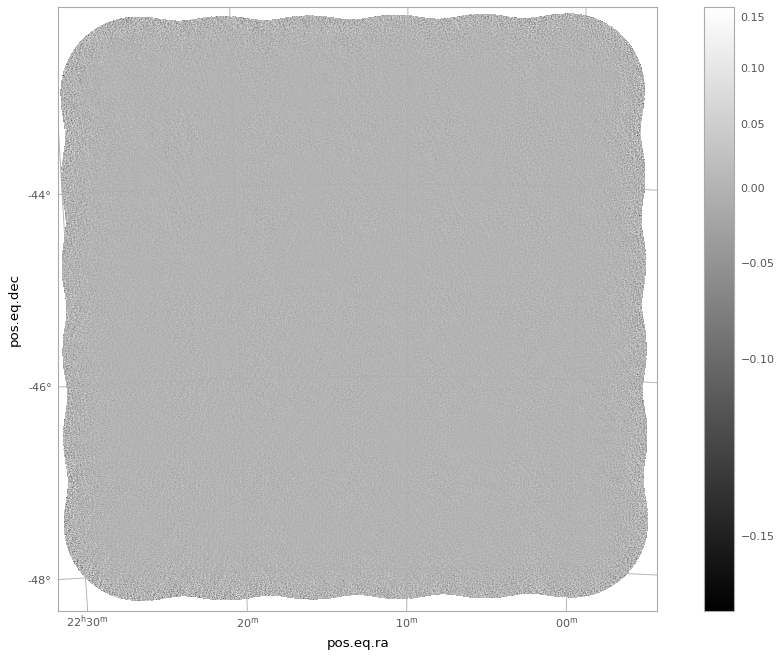

In [30]:
x=image_data[0,0,:,:]
import matplotlib.pyplot as pl
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(stretch=SqrtStretch())

plt.figure(figsize=(15,10), dpi= 80)
plt.subplot(projection=wcs, slices=('x', 'y', 0,0))
plt.imshow(x, cmap='gray', norm=norm)
plt.colorbar()

### Example 2 - smaller images, for ten channels

Now that we know how to extract a subset of full images over a predetermined number of channels, lets try a more complex example. Firstly, whats the range of the original cube? The positional and channel data has been saved into the table sparkfits_detail_arrays as part of the ETL data load process. Lets have a look at the table.

Here's the table schema

In [31]:
sqlContext.sql("desc sparkfits_detail_arrays").show()

+--------------------+------------+-------+
|            col_name|   data_type|comment|
+--------------------+------------+-------+
|    sda_detail_array|array<float>|   null|
|        sda_filename|      string|   null|
|     sda_detail_type|      string|   null|
|# Partition Infor...|            |       |
|          # col_name|   data_type|comment|
|        sda_filename|      string|   null|
|     sda_detail_type|      string|   null|
+--------------------+------------+-------+



Now lets have a look at the data

In [32]:
sqlContext.sql("select sda_filename, sda_detail_type, sda_detail_array from sparkfits_detail_arrays").show()

+--------------------+---------------+--------------------+
|        sda_filename|sda_detail_type|    sda_detail_array|
+--------------------+---------------+--------------------+
|residual.i.SB8170...|            GHz|[1.2955, 1.295518...|
|residual.i.SB8170...|             Hz|[1.29550003E9, 1....|
|residual.i.SB8170...|         km s-1|[-1.94190534E12, ...|
|residual.i.SB8170...|            GHz|[1.2955, 1.295518...|
|residual.i.SB8170...|             Hz|[1.29550003E9, 1....|
|residual.i.SB8170...|         km s-1|[-1.94190534E12, ...|
|image.restored.i....|       DEC--SIN|[-48.329792, -48....|
|image.restored.i....|       DEC--SIN|[-42.05753, -42.0...|
|image.restored.i....|       RA---SIN|[337.9597, 337.95...|
|image.restored.i....|       RA---SIN|[337.9597, 337.95...|
|residual.i.SB8170...|       RA---SIN|[59.229744, 59.22...|
|residual.i.SB8170...|       RA---SIN|[59.229744, 59.22...|
|residual.i.SB8170...|       DEC--SIN|[-27.01964, -27.0...|
|residual.i.SB8170...|       DEC--SIN|[-

What we can see here is that we have the positional data for every file loaded into the images table, sparkfits_images, as well as multiple arrays for channel and frequency data. The original cube had frequency data in Hz, but using the SpectralCube package we also recorded spectra values for velocity and GHz. 

We'll continue to use Hz data; these additional spectra values were created to demonstrate the capability of the data model to support multiple positional and channel formats.

Lets extract the positional and frequency array data for our cube. Remember, we have already set the filename, position and frequency types above -

* fitsFilename='image.restored.i.SB2338.V2.cube.fits'
* raType='RA---SIN'
* decType='DEC--SIN'
* spectraType='Hz'

We'll create datagrames of the array data using the posexplode function

In [33]:
fitsFilename, raType, decType, spectraType

('image.restored.i.SB2338.V2.cube.fits', 'RA---SIN', 'DEC--SIN', 'Hz')

In [34]:
raDF=sqlContext.sql("""
with data as 
(
    select posexplode(sda_detail_array)
    from sparkfits_detail_arrays
    where sda_filename='image.restored.i.SB2338.V2.cube.fits'
    and sda_detail_type='RA---SIN'
)
select pos as sda_index, float(col) as sda_right_ascension from data

"""      )
raDF.show()

+---------+-------------------+
|sda_index|sda_right_ascension|
+---------+-------------------+
|        0|           337.9597|
|        1|          337.95804|
|        2|          337.95636|
|        3|          337.95468|
|        4|            337.953|
|        5|          337.95135|
|        6|          337.94968|
|        7|            337.948|
|        8|          337.94632|
|        9|          337.94467|
|       10|            337.943|
|       11|           337.9413|
|       12|          337.93964|
|       13|            337.938|
|       14|           337.9363|
|       15|          337.93463|
|       16|          337.93295|
|       17|           337.9313|
|       18|          337.92963|
|       19|          337.92795|
+---------+-------------------+
only showing top 20 rows



In [35]:
decDF=sqlContext.sql("""
with data as 
(
    select posexplode(sda_detail_array)
    from sparkfits_detail_arrays
    where sda_filename='image.restored.i.SB2338.V2.cube.fits'
    and sda_detail_type='DEC--SIN'
)
select pos as sda_index, float(col) as sda_declination from data

"""      )
decDF.show()

+---------+---------------+
|sda_index|sda_declination|
+---------+---------------+
|        0|      -42.05753|
|        1|      -42.05864|
|        2|      -42.05975|
|        3|      -42.06086|
|        4|      -42.06197|
|        5|      -42.06308|
|        6|     -42.064194|
|        7|     -42.065304|
|        8|     -42.066414|
|        9|     -42.067524|
|       10|     -42.068634|
|       11|     -42.069744|
|       12|     -42.070854|
|       13|     -42.071968|
|       14|      -42.07308|
|       15|      -42.07419|
|       16|       -42.0753|
|       17|      -42.07641|
|       18|      -42.07752|
|       19|      -42.07863|
+---------+---------------+
only showing top 20 rows



In [36]:
freqDF=sqlContext.sql("""
with data as 
(
    select posexplode(sda_detail_array)
    from sparkfits_detail_arrays
    where sda_filename='image.restored.i.SB2338.V2.cube.fits'
    and sda_detail_type='Hz'
)
select pos as sda_index, float(col) as sda_Frequency_hz from data

"""      )
freqDF.show()

+---------+----------------+
|sda_index|sda_Frequency_hz|
+---------+----------------+
|        0|    1.37649997E9|
|        1|    1.37651853E9|
|        2|    1.37653709E9|
|        3|    1.37655552E9|
|        4|    1.37657408E9|
|        5|    1.37659264E9|
|        6|    1.37661107E9|
|        7|    1.37662963E9|
|        8|    1.37664819E9|
|        9|    1.37666662E9|
|       10|    1.37668518E9|
|       11|    1.37670374E9|
|       12|    1.37672218E9|
|       13|    1.37674074E9|
|       14|     1.3767593E9|
|       15|    1.37677773E9|
|       16|    1.37679629E9|
|       17|    1.37681485E9|
|       18|    1.37683328E9|
|       19|    1.37685184E9|
+---------+----------------+
only showing top 20 rows



We'll demonstrate two methods of extracting sub cubes below, as well as extracting the position and schema arrays to get the ranges of the cube.

First, we'll register the position and dataframes as temporary tables.

In [37]:
raDF.registerTempTable("RIGHT_ASCENSIONS")
decDF.registerTempTable("DECLINATIONS")
freqDF.registerTempTable("FREQUENCIES")

As an example, we'll get the position and frequency arrays. Note that we're using the .collect() method here.

In [38]:
raArray=np.array(sqlContext.sql("""select sda_right_ascension from RIGHT_ASCENSIONS """).collect())
decArray=np.array(sqlContext.sql("""select sda_declination from DECLINATIONS """).collect())
spectraArray=np.array(sqlContext.sql("""select sda_Frequency_hz from FREQUENCIES """).collect())

So, what ranges do we have in this cube?

In [39]:
print("Range of Ra {} to {}".format( max(raArray), min(raArray)))
print("Range of Declination {} to {}".format( max(decArray), min(decArray)))
print("Frequency ranges in {} - {} {}".format(spectraType, min(spectraArray), max(spectraArray))) 

Range of Ra [337.95968628] to [328.5758667]
Range of Declination [-42.05752945] to [-48.32979202]
Frequency ranges in Hz - [1.37649997e+09] [1.42448154e+09]


Converting between degrees and HMS for right ascension - we could write our own utilities but why reinvent the wheel? For these examples, there's a couple of functions from http://www.bdnyc.org/2012/10/decimal-deg-to-hms/ written by Joe Filippazzo that'll do the trick. You can write your own if you feel so inclined.

Converting the Right Ascension in degrees into HH:MM:SS

In [40]:
print("Range of Ra in hh:mm:ss {} to {}".format( deg2HMS(ra=max(raArray)), deg2HMS(ra=min(raArray))  ))


Range of Ra in hh:mm:ss 22 31 [50.32470703] to 21 54 [18.20800781]


Now we have the range of the cube. Note that the array indexes match the position and spectra values from the original cube. This becomes important later, as we will see.

Lets assume we're interested in the position range between Right Ascension 22h10m and 22h20m and declination -46 to -47 degrees, for channel frequencies we want the frequency data between 1376759296 and 1376870400 Hz.

What Ra range in degrees do we want?

In [41]:
print("Required range of Ra in degrees - {} to {}".format( HMS2deg(ra='22 10 00.000'), HMS2deg(ra='22 20 00.000')))   

Required range of Ra in degrees - 332.5 to 335.0


Because the Right Ascension data is contained in the index position of the spi_image column in the images table (remembering tha the spi_image column is an array!) we create a list that we will use to get the subset of the parquet array we want.

In [42]:
raSelectRange=np.where(np.logical_and(raArray >= 332.5, raArray <= 335))
raSelectList=raSelectRange[0].tolist()

In [43]:
raSelectList

[1770,
 1771,
 1772,
 1773,
 1774,
 1775,
 1776,
 1777,
 1778,
 1779,
 1780,
 1781,
 1782,
 1783,
 1784,
 1785,
 1786,
 1787,
 1788,
 1789,
 1790,
 1791,
 1792,
 1793,
 1794,
 1795,
 1796,
 1797,
 1798,
 1799,
 1800,
 1801,
 1802,
 1803,
 1804,
 1805,
 1806,
 1807,
 1808,
 1809,
 1810,
 1811,
 1812,
 1813,
 1814,
 1815,
 1816,
 1817,
 1818,
 1819,
 1820,
 1821,
 1822,
 1823,
 1824,
 1825,
 1826,
 1827,
 1828,
 1829,
 1830,
 1831,
 1832,
 1833,
 1834,
 1835,
 1836,
 1837,
 1838,
 1839,
 1840,
 1841,
 1842,
 1843,
 1844,
 1845,
 1846,
 1847,
 1848,
 1849,
 1850,
 1851,
 1852,
 1853,
 1854,
 1855,
 1856,
 1857,
 1858,
 1859,
 1860,
 1861,
 1862,
 1863,
 1864,
 1865,
 1866,
 1867,
 1868,
 1869,
 1870,
 1871,
 1872,
 1873,
 1874,
 1875,
 1876,
 1877,
 1878,
 1879,
 1880,
 1881,
 1882,
 1883,
 1884,
 1885,
 1886,
 1887,
 1888,
 1889,
 1890,
 1891,
 1892,
 1893,
 1894,
 1895,
 1896,
 1897,
 1898,
 1899,
 1900,
 1901,
 1902,
 1903,
 1904,
 1905,
 1906,
 1907,
 1908,
 1909,
 1910,
 1911,
 1912,

In [44]:
spectraArray[14][0]

1376759296.0

Lets assume we want the declination range -44 to -46, and the frequencies between 1.37653709E9 and 1.3767593E9.

Now we have the information we need to extract the sub cube.

### Now we create a dataframe of the images table.

Remember here that Spark performs lazy evaluation - the dataframe is not instantiated until we call an action on it. Don't forget to include the predicate for the filename! This ensures we don't do a full table scan which will be really expensive if we have an images table with multiple large fits files in it.

In [45]:
myImageDF=sqlContext.sql("select * from sparkfits_images where spi_filename='{}' ".format(fitsFilename))

and register it as a temporary table

In [46]:
myImageDF.registerTempTable("IMAGES")

We'll demonstrate two methods here of creating the sub cube dataframe.

## METHOD 1

Using Spark dataframes. Using the dataframes we have already created, we'll filter these dataframes for the data we require. Also, notice that when we are creating the actual sub cube dataframe, we're using broadcast joins on the smaller dimensional dataframes.


In [104]:
raFilterDF    = raDF.filter((raDF.sda_right_ascension <= 335 ) & (raDF.sda_right_ascension >= 334.75))

raSelectRange=np.where(np.logical_and(raArray >= 334.5, raArray <= 335))
raSelectList=raSelectRange[0].tolist()

decFilterDF   = decDF.filter((decDF.sda_declination <= -44 ) & (decDF.sda_declination >= -44.5 ))
freqFilterDF  = freqDF.filter((freqDF.sda_Frequency_hz <= spectraArray[17][0] ) \
                              & (freqDF.sda_Frequency_hz >= spectraArray[14][0] ))

In [105]:
timer.start()
subCubeDF=myImageDF.join(broadcast(freqFilterDF), myImageDF.spi_band == freqFilterDF.sda_index)\
.join(broadcast(decFilterDF), myImageDF.spi_index == decFilterDF.sda_index)\
.withColumn("raSelectRange", f.array([f.col("spi_image")[i] for i in raSelectList  ] ))\
.select("spi_index","raSelectRange","spi_filename","spi_band")
print("Image dataframe created")
timer.stop()

Image dataframe created
Elapsed 0.8s, CPU 0.4s


So now we have a dataframe representing the new subcube. Let's have a look at it. Note that the colum we created with the filtered right ascension data is currently called "raSelectRange"

In [49]:
subCubeDF.show()

+---------+--------------------+--------------------+--------+
|spi_index|       raSelectRange|        spi_filename|spi_band|
+---------+--------------------+--------------------+--------+
|     1751|[-0.015688935, -0...|image.restored.i....|      14|
|     1752|[-0.013127964, -0...|image.restored.i....|      14|
|     1753|[-0.010117485, -0...|image.restored.i....|      14|
|     1754|[-0.006994534, -0...|image.restored.i....|      14|
|     1755|[-0.003980589, -0...|image.restored.i....|      14|
|     1756|[-0.0011706426, -...|image.restored.i....|      14|
|     1757|[0.0014200128, -3...|image.restored.i....|      14|
|     1758|[0.0037872335, 0....|image.restored.i....|      14|
|     1759|[0.0058900993, 0....|image.restored.i....|      14|
|     1760|[0.0076451222, 0....|image.restored.i....|      14|
|     1761|[0.0089522265, 0....|image.restored.i....|      14|
|     1762|[0.009723827, 0.0...|image.restored.i....|      14|
|     1763|[0.009896413, 0.0...|image.restored.i....|  

We'll demonstrate two methods here of creating the sub cube dataframe.

## METHOD 2

Using Spark and Hive SQL. We use the dataframes instantiated as temporary table we created previouslyUsing the dataframes we have already created, we'll filter these dataframes for the data we require. Also, notice that when we are creating the actual sub cube dataframe, we're using broadcast joins on the smaller dimensional dataframes.

In [50]:
subCubeSQLDF=sqlContext.sql("""
select /*+ BROADCAST(DECLINATIONS), BROADCAST(FREQUENCIES) */
spi_index, spi_image, spi_filename,spi_band
from IMAGES
    INNER JOIN FREQUENCIES
        on IMAGES.spi_band == FREQUENCIES.sda_index
    INNER JOIN DECLINATIONS
        on IMAGES.spi_index == DECLINATIONS.sda_index
        
    WHERE FREQUENCIES.sda_Frequency_hz <= {}
        AND FREQUENCIES.sda_Frequency_hz >= {}
    AND DECLINATIONS.sda_declination <= -44 
        AND DECLINATIONS.sda_declination >= -46
        
    ORDER BY spi_band, spi_index
""".format(spectraArray[17][0], spectraArray[14][0])) #.explain()

In [51]:
subCubeSQLDF.printSchema()

root
 |-- spi_index: integer (nullable = true)
 |-- spi_image: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- spi_filename: string (nullable = true)
 |-- spi_band: integer (nullable = true)



We still have to apply the RA filter, so - 

In [52]:
timer.start()
subCubeSQLDF=subCubeSQLDF\
.withColumn("raSelectRange", f.array([f.col("spi_image")[i] for i in raSelectList  ] ))\
.select("spi_index","raSelectRange","spi_filename","spi_band")
print("Image dataframe created")
timer.stop()

Image dataframe created
Elapsed 2.8s, CPU 0.6s


In [69]:
subCubeDF.show()

+---------+--------------------+--------------------+--------+
|spi_index|       raSelectRange|        spi_filename|spi_band|
+---------+--------------------+--------------------+--------+
|     1751|[-0.015688935, -0...|image.restored.i....|      14|
|     1752|[-0.013127964, -0...|image.restored.i....|      14|
|     1753|[-0.010117485, -0...|image.restored.i....|      14|
|     1754|[-0.006994534, -0...|image.restored.i....|      14|
|     1755|[-0.003980589, -0...|image.restored.i....|      14|
|     1756|[-0.0011706426, -...|image.restored.i....|      14|
|     1757|[0.0014200128, -3...|image.restored.i....|      14|
|     1758|[0.0037872335, 0....|image.restored.i....|      14|
|     1759|[0.0058900993, 0....|image.restored.i....|      14|
|     1760|[0.0076451222, 0....|image.restored.i....|      14|
|     1761|[0.0089522265, 0....|image.restored.i....|      14|
|     1762|[0.009723827, 0.0...|image.restored.i....|      14|
|     1763|[0.009896413, 0.0...|image.restored.i....|  

In [54]:
subCubeDF.select(col("raSelectRange")).show()

+--------------------+
|       raSelectRange|
+--------------------+
|[-0.015688935, -0...|
|[-0.013127964, -0...|
|[-0.010117485, -0...|
|[-0.006994534, -0...|
|[-0.003980589, -0...|
|[-0.0011706426, -...|
|[0.0014200128, -3...|
|[0.0037872335, 0....|
|[0.0058900993, 0....|
|[0.0076451222, 0....|
|[0.0089522265, 0....|
|[0.009723827, 0.0...|
|[0.009896413, 0.0...|
|[0.009428267, 0.0...|
|[0.0083038015, 0....|
|[0.0065596644, 0....|
|[0.0043256483, 0....|
|[0.0018551686, 0....|
|[-4.847243E-4, -6...|
|[-0.0022858877, -...|
+--------------------+
only showing top 20 rows



In [56]:
subCubeDF.filter((subCubeDF.spi_band == 14) ).select(col("raSelectRange")).show()

+--------------------+
|       raSelectRange|
+--------------------+
|[-0.015688935, -0...|
|[-0.013127964, -0...|
|[-0.010117485, -0...|
|[-0.006994534, -0...|
|[-0.003980589, -0...|
|[-0.0011706426, -...|
|[0.0014200128, -3...|
|[0.0037872335, 0....|
|[0.0058900993, 0....|
|[0.0076451222, 0....|
|[0.0089522265, 0....|
|[0.009723827, 0.0...|
|[0.009896413, 0.0...|
|[0.009428267, 0.0...|
|[0.0083038015, 0....|
|[0.0065596644, 0....|
|[0.0043256483, 0....|
|[0.0018551686, 0....|
|[-4.847243E-4, -6...|
|[-0.0022858877, -...|
+--------------------+
only showing top 20 rows



In [106]:
subCubeChannel14DF=subCubeDF.filter((subCubeDF.spi_band == 14) ).select(col("raSelectRange"))

#### Show one channel from the sub cube

In [107]:
data=np.array( subCubeChannel14DF.collect() )
print(data.shape)

(451, 1, 298)


In [108]:
data=data.reshape(data.shape[0], data.shape[2])

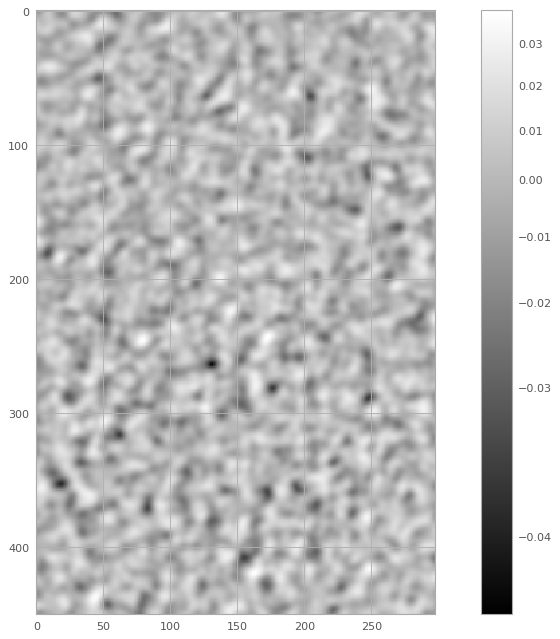

In [109]:
from astropy.utils.data import download_file
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(stretch=SqrtStretch())
plt.figure(figsize=(15,10), dpi= 80)
#plt.subplot(projection=myWcs, slices=('x', 'y', 0,0))
plt.imshow(data, cmap='gray', norm=norm)
plt.colorbar()

#### Run the DAOStarFinder againt the data, see what it throws up

In [100]:
imRDD = subCubeChannel14DF.rdd.coalesce(1).glom()

In [101]:
def reshape_image(im):
    """
    By default, Spark shapes images into (nx, 1, ny).
    This routine reshapes images into (nx, ny)

    Parameters
    ----------
    im : 3D array
        Original image with shape (nx, 1, ny)

    Returns
    ----------
    im_reshaped : 2D array
        Original image with shape (nx, ny)
        
    """
    shape = np.array(np.shape(im))
    shape=np.delete(shape, np.where(shape==1))
    return im.reshape(shape)

In [102]:
def get_stat(data, sigma=3.0, iters=3):
    """
    Estimate the background and background noise using
    sigma-clipped statistics.

    Parameters
    ----------
    data : 2D array
        2d array containing the data.
    sigma : float
        sigma.
    iters : int
        Number of iteration to perform to get accurate estimate.
        The higher the better, but it will be longer.
    """
    mean, median, std = sigma_clipped_stats(data, sigma=sigma, maxiters=iters)
    return mean, median, std

In [103]:
cat = imRDD.map(
    lambda im: reshape_image(np.array(im)))\
    .map(
        lambda im: (im, get_stat(im)))\
    .map(
        lambda im_stat: (
            im_stat[0],
            im_stat[1][1],
            DAOStarFinder(fwhm=3.0, threshold=5.*im_stat[1][2])))\
    .map(
        lambda im_mean_starfinder: im_mean_starfinder[2](
            im_mean_starfinder[0] - im_mean_starfinder[1]))

final_cat = cat.collect()
print(final_cat)

[None]
